In [5]:
%load_ext autoreload
%autoreload 2

# Training different models with and without expert info

We wanted to see the impact of expert information in the final prediction

In [6]:
from typing import Optional, Callable, List, Dict
import sys
import logging

import ipywidgets as widgets
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')

In [7]:
from src.data import load_data
from src import config
from src.preprocessing.dataset import generate_dataset, get_is_day
from src.preprocessing.aoi import get_aoi_year_location

## Constants

You can select the different values here and run all the cells, it will train different models with those parameters

In [8]:
# The period of a day (DO NOT CHANGE)
PERIOD = 96

# The location for which we want to generate the data (in pixels)
LOC_X = 200
LOC_Y = 200

# We train the model for one year, and it use another year for testing purpose (maybe not all the year)
YEAR_TRAIN = 2020
YEAR_TEST = 2019

# Size of the training set (-1 <=> all), to speed the process if needed
DATASET_SIZE = -1

# The number of points to generate at the end (20 days here)
NUMBER_TO_GENERATE = PERIOD * 20

# The number of lag points the models will have to predict the next
SHIFT_SIZE = 20


# EXPERT DATA
## Add info if the next point will with the sun or not (if it is day or not)
ADD_IS_DAY = True
## Add the angle of incidence to help the model predict
ADD_AOI = True

# To avoid that some models just predict 0 all the time
# We remove some instances of the dataset for which the 
# prediction should be 0 (during the night)
REMOVE_0 = False

In [9]:
assert DATASET_SIZE > NUMBER_TO_GENERATE + SHIFT_SIZE or DATASET_SIZE==-1

train_data = load_data("../data", YEAR_TRAIN)[:DATASET_SIZE, LOC_X, LOC_Y]
test_data = load_data("../data", YEAR_TEST)[:DATASET_SIZE, LOC_X, LOC_Y]


print(train_data.shape, test_data.shape)

(35135,) (35039,)


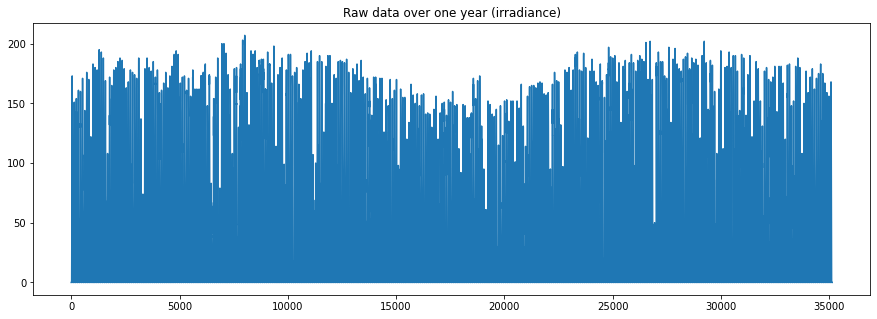

In [10]:
plt.figure(figsize=(15,5))
plt.plot(train_data)
plt.title('Raw data over one year (irradiance)')
plt.show()

## Generate the datasets for the models

If we add expert knowledge, we load it too here

In [11]:
# Original X_train and X_test
X_train, y_train, train_indexes = generate_dataset(train_data, shift=SHIFT_SIZE, make_diff=False, remove_some_0=REMOVE_0)
X_test, y_test, test_indexes = generate_dataset(test_data, shift=SHIFT_SIZE, make_diff=False,remove_some_0=False)


# Compute the IS DAY 
if ADD_IS_DAY:
    print("Adding is day...")
    train_is_day = get_is_day(size=train_data.shape[0], shift=SHIFT_SIZE)
    test_is_day = get_is_day(size=test_data.shape[0], shift=SHIFT_SIZE)

    if train_indexes is not None:
        train_is_day = train_is_day[train_indexes]
    if test_indexes is not None:
        test_is_day = test_is_day[test_indexes]
    print("train is_day shape", train_is_day.shape)
    print("test is_day shape", test_is_day.shape)
else:
    train_is_day = None
    test_is_day = None

# Compute the AOI
if ADD_AOI:
    print("Adding AOI...")
    train_aoi = get_aoi_year_location(LOC_X, LOC_Y, YEAR_TRAIN, SHIFT_SIZE)
    test_aoi = get_aoi_year_location(LOC_X, LOC_Y, YEAR_TEST, SHIFT_SIZE)
    if train_indexes is not None:
        train_aoi = train_aoi[train_indexes]
    if test_indexes is not None:
        test_aoi = test_aoi[test_indexes]

    print("train AOI", train_aoi.shape)
    print("test AOI", test_aoi.shape)
else:
    train_aoi = None
    test_aoi = None

print("train", X_train.shape, y_train.shape)
print("test", X_test.shape, y_test.shape)


Adding is day...
train is_day shape (35115,)
test is_day shape (35019,)
Adding AOI...
train AOI (35115,)
test AOI (35019,)
train (35115, 20) (35115,)
test (35019, 20) (35019,)


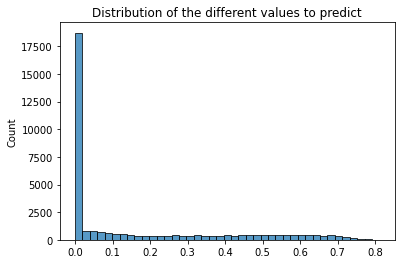

In [12]:
plt.figure()
plt.title('Distribution of the different values to predict')
sns.histplot(y_train);

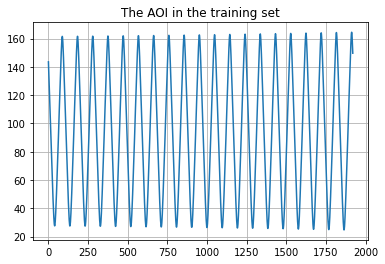

In [13]:
if train_aoi is not None:
    plt.figure()
    plt.title('The AOI in the training set')
    plt.plot(range(NUMBER_TO_GENERATE), train_aoi[:NUMBER_TO_GENERATE])
    plt.grid()
    plt.show()

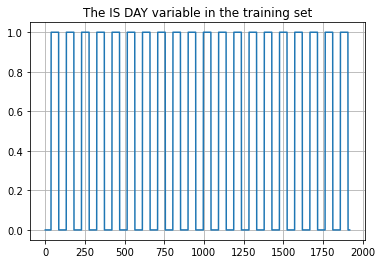

In [14]:
if train_is_day is not None:
    plt.figure()
    plt.title('The IS DAY variable in the training set')
    plt.plot(range(NUMBER_TO_GENERATE), train_is_day[:NUMBER_TO_GENERATE])
    plt.grid()
    plt.show()

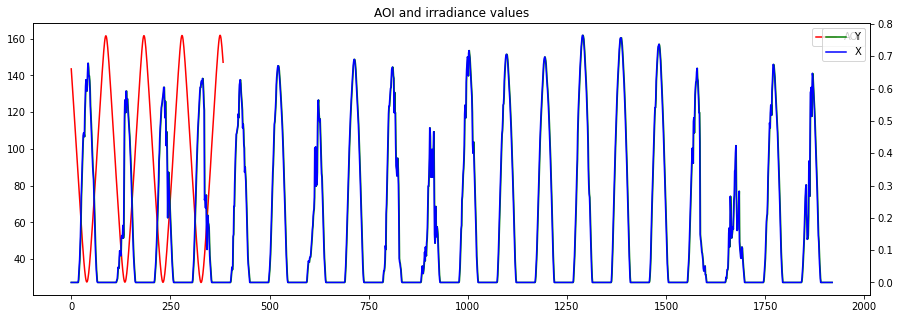

In [15]:
if ADD_AOI:
    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.plot(train_aoi[:PERIOD*4], label="AOI", color="red")
    plt.legend()
    ax2 = ax1.twinx()
    ax2.plot(y_train[:NUMBER_TO_GENERATE], label="Y", color="green")
    ax2.plot(X_train[:NUMBER_TO_GENERATE,-1], label="X", color="blue")
    plt.legend()
    plt.title("AOI and irradiance values")
    plt.show()

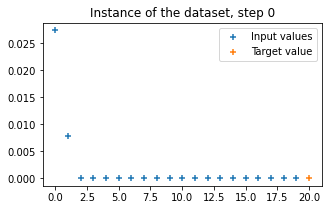

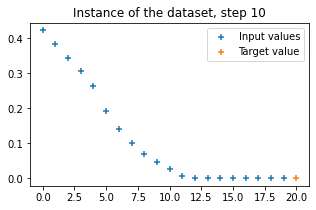

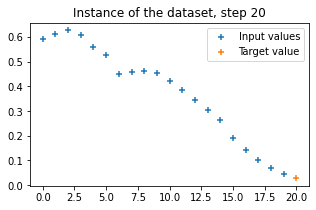

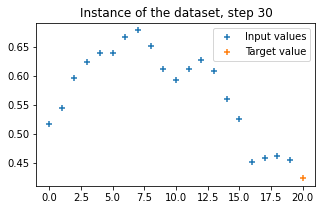

In [16]:
step = 10
for i, (x, y) in enumerate(zip(X_train, y_train)):
    if i % step != 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.scatter(np.array(range(x.shape[0])), x, label="Input values", marker="+")
    plt.scatter([x.shape[0]], y, label="Target value", marker="+")
    plt.legend()
    plt.title(f"Instance of the dataset, step {i}")
    if i > step * 2:
        break


## Models

We can load different models here, to make it work, it just needs to implement the **.fit** and the **.predict** methods

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

In [32]:
class DummyModel():
    """Dummy model.
    
    Consider that the weather/irradiance is the same today than yesterday.
    """
    def fit(self, *args, **kwargs):
        pass

    def predict(self, X):
        if X.shape[1]>=PERIOD:
            return X[:, -PERIOD]
        return X[:,-1]

In [33]:
models = {
    "LinearRegression": LinearRegression(),
    #"DecisionTreeRegressor": DecisionTreeRegressor(max_depth=2),
    "DecisionTreeRegressor2": DecisionTreeRegressor(max_depth=10),
    "DecisionTreeRegressor3": DecisionTreeRegressor(max_depth=100),
    "DecisionTreeRegressor4": DecisionTreeRegressor(max_depth=500),
    "PolynomialRegression": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    "neural_net": MLPRegressor(
        hidden_layer_sizes=(30, 30, 10, 1),
        activation="relu",
        solver="adam",
        learning_rate="constant",
        learning_rate_init=1e-3
    ),
    "dummy": DummyModel()
}

del models['PolynomialRegression'] # We don't want to test this one, goes to crazy

In [34]:
selection_checkboxes = [widgets.Checkbox(value=True, description=label) for label in models]
output = widgets.VBox(children=selection_checkboxes)
print('Select the models you want to train:')
display(output)

Select the models you want to train:


In [35]:
selected_models = set([
    checkbox.description for checkbox in selection_checkboxes if checkbox.value
])
print(f"Running the evaluation with {', '.join(selected_models)}")

models = {k:v for k,v in models.items() if k in selected_models}

Running the evaluation with dummy, DecisionTreeRegressor3, neural_net, LinearRegression, DecisionTreeRegressor4, DecisionTreeRegressor2


### Model training

If we add expert knowledge, we concatenate the values together

In [36]:
# Before the training, we will create the real input values that we will input in the mode
to_concatenate = [X_train]
if train_is_day is not None:
    to_concatenate.append(train_is_day.reshape((-1, 1)))
if train_aoi is not None:
    to_concatenate.append(train_aoi.reshape((-1, 1)))


X_train_ = np.concatenate(to_concatenate, axis=-1)


for model_name, model in models.items():
    print(f"{model_name} ...")
    model.fit(X_train_, y_train)
    print(f"{model_name} DONE")
print('Done !')

LinearRegression ...
LinearRegression DONE
DecisionTreeRegressor2 ...
DecisionTreeRegressor2 DONE
DecisionTreeRegressor3 ...
DecisionTreeRegressor3 DONE
DecisionTreeRegressor4 ...
DecisionTreeRegressor4 DONE
neural_net ...
neural_net DONE
dummy ...
dummy DONE
Done !


### Model predictions

We select one starting point in the testing set (`IDX`) and prepare the values they will need to predict

In [37]:
IDX = 10

x_initial = X_test[IDX]
y_truth = y_test[IDX:IDX+NUMBER_TO_GENERATE]

# Check the sizes
assert x_initial.shape == (SHIFT_SIZE,), f"{x_initial.shape} != ({SHIFT_SIZE},)"
assert y_truth.shape == (NUMBER_TO_GENERATE,), f"{y_truth.shape} != ({NUMBER_TO_GENERATE},)"

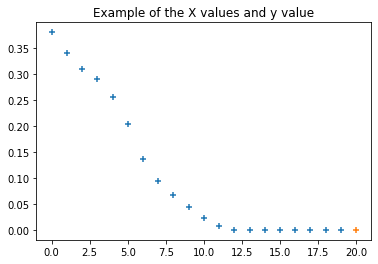

In [38]:
plt.scatter(range(x_initial.shape[0]), x_initial, marker="+")
plt.scatter([x_initial.shape[0]], y_truth[:1], marker="+")
plt.title("Example of the X values and y value")
plt.show();

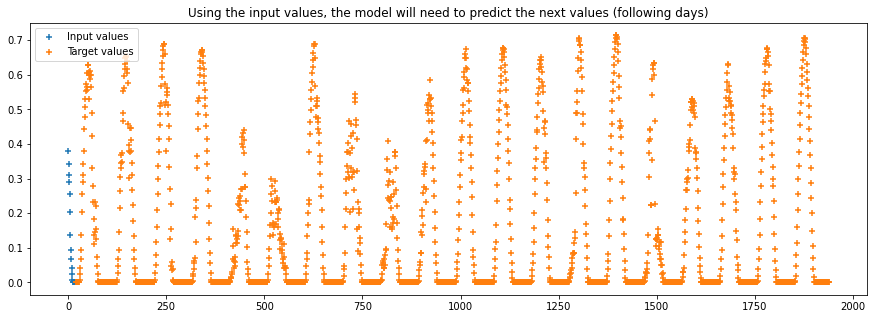

In [39]:
plt.figure(figsize=(15,5))
plt.scatter(range(SHIFT_SIZE), x_initial[:SHIFT_SIZE], marker="+", label="Input values")
plt.scatter(range(SHIFT_SIZE, SHIFT_SIZE+NUMBER_TO_GENERATE), y_truth[:NUMBER_TO_GENERATE], marker="+", label="Target values")
plt.title("Using the input values, the model will need to predict the next values (following days)")
plt.legend()
plt.show()

100%|██████████| 1920/1920 [00:00<00:00, 193676.38it/s]


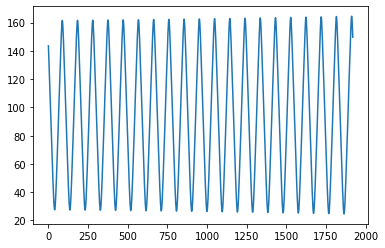

In [40]:
def predict_next_values(pred_func: Callable, x_initial: np.ndarray, how_many: int, is_day: np.ndarray, aoi_values: np.ndarray):
    """Predict the next values.
    
    Using the model `.predict()` method, some initial values, and if needed the expert knowledge.
    """
    size = SHIFT_SIZE
    predictions = np.zeros((1, size+how_many))
    predictions[0,:size] = x_initial[-size:]
    
    try:
        for i in tqdm(range(how_many)):
            x = predictions[:,i:i+size]

            # If needed, we add the AOI and/or the is_day
            to_concat = [x[0]]
            if is_day is not None:
                to_concat.append(is_day[i:i+1])
            if aoi_values is not None:
                to_concat.append(aoi_values[i:i+1])
            if len(to_concat)>1:
                x = np.concatenate(to_concat, axis=-1).reshape((1, -1))

            
            predictions[0,size + i] = pred_func(x)[0]
    except Exception as e:
        # For some strange reasons, sometimes we get errors with some custom models
        # We shouldn't do that, but we will just stop the prediction here
        # and return what we have
        print(e)
    return predictions[0,size:]

plt.plot(predict_next_values(models['dummy'].predict, x_initial, NUMBER_TO_GENERATE, test_is_day, test_aoi));

In [78]:
print('Predictions to display:')
pred_checkboxes = [widgets.Checkbox(value=True, description=label) for label in models]
output = widgets.VBox(children=pred_checkboxes)
display(output)

Predictions to display:


In [79]:
selected_models = set([
    checkbox.description for checkbox in pred_checkboxes if checkbox.value
])
print(f"Prediction and display the following models: {', '.join(selected_models)}")

Prediction and display the following models: dummy, DecisionTreeRegressor3, neural_net, LinearRegression, DecisionTreeRegressor4, DecisionTreeRegressor2


In [80]:
predictions = {
    model_name: predict_next_values(
        pred_func=model.predict, x_initial=x_initial, how_many=NUMBER_TO_GENERATE,
        is_day=test_is_day, aoi_values=test_aoi
            
    )
    for model_name, model in models.items()
    if model_name in selected_models
}

100%|██████████| 1920/1920 [00:00<00:00, 115267.72it/s]


In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def plot_prediction_and_metrics(x_initial: np.ndarray, y_truth: np.ndarray, y_preds: Dict[str, np.ndarray], offset=12, nbr_points: int = PERIOD * 2):
    """Plot the prediction."""
    plt.figure(figsize=(30, 10))
    plt.ylim(-0.2, 1.1)
    plt.plot(x_initial[:SHIFT_SIZE], label="Initial values", marker="+")
    idx = np.array(range(SHIFT_SIZE, SHIFT_SIZE + y_truth.shape[0]))
    plt.plot(idx[:nbr_points], y_truth[:nbr_points], label="Truth", marker="+")
    
    results = {}
    for model_name, y_pred in y_preds.items():
        results[model_name] = {
            "mse": mean_squared_error(y_truth[:-offset], y_pred[offset:]),
            "mae": mean_absolute_error(y_truth[:-offset], y_pred[offset:]),
            "r2": r2_score(y_truth[:-offset], y_pred[offset:])
        }
        plt.plot(idx[:nbr_points], y_pred[offset:offset+nbr_points], label=f"Prediction with {model_name}", marker="+")

    plt.grid()
    plt.legend()
    plt.savefig('../docs/model_predictions.png', transparent=True)
    plt.title("Predictions of the different models")
    plt.show()
    return results


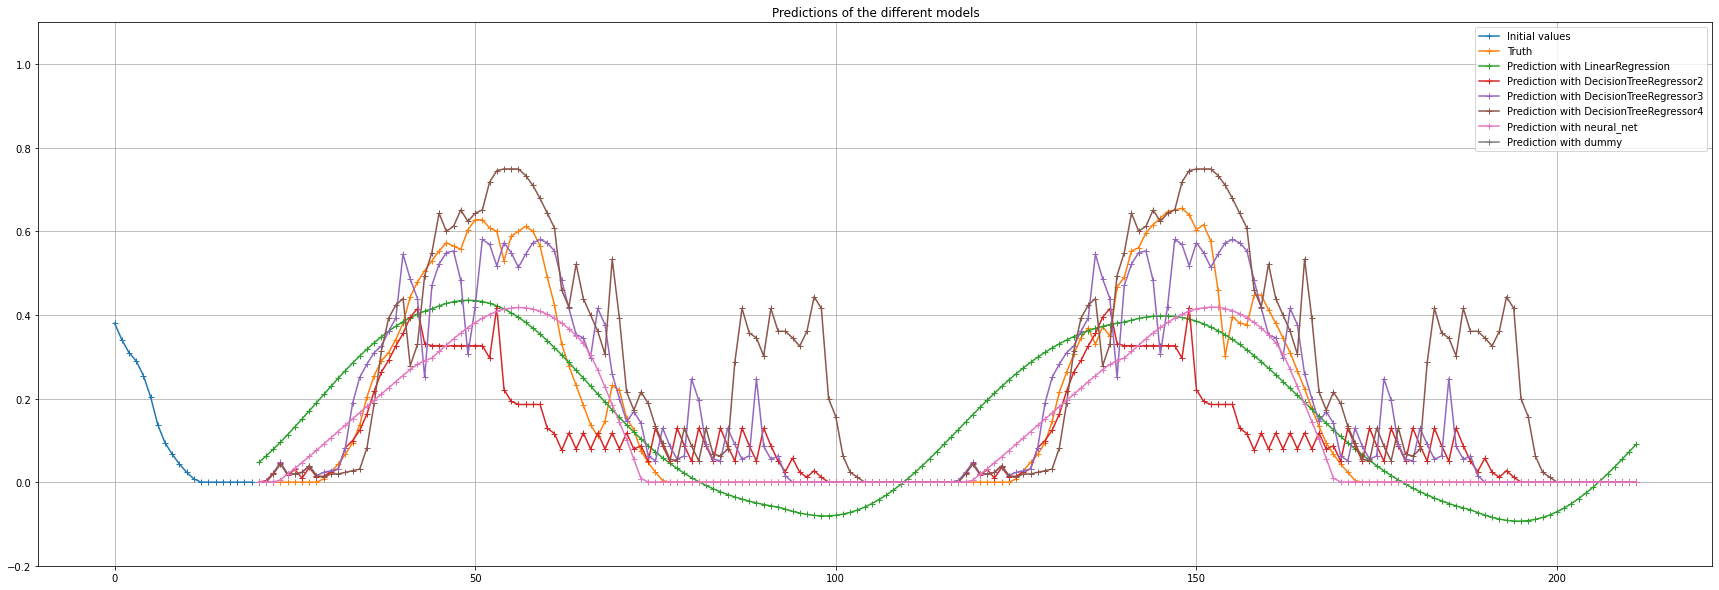

In [87]:
results = plot_prediction_and_metrics(
    x_initial,
    y_truth,
    predictions
)


### Saving the results

To make it possible to compare the different models in different conditions

In [88]:
results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'model'})


results_df['loc_x'] = LOC_X
results_df['loc_y'] = LOC_Y
results_df['year_train'] = YEAR_TRAIN
results_df['year_test'] = YEAR_TEST
results_df['dataset_size'] = DATASET_SIZE
results_df['number_to_generate'] = NUMBER_TO_GENERATE
results_df['shift_size'] = SHIFT_SIZE
results_df['add_is_day'] = ADD_IS_DAY
results_df['add_aoi'] = ADD_AOI
results_df['remove_0'] = REMOVE_0

path = "./results.csv"
import os
if os.path.isfile(path):
    results_df = pd.concat([results_df, pd.read_csv(path, index_col=0)])
results_df.to_csv(path)

# Models explicability

To understand how some models are working, we will do a bit of explicability

In [89]:
# Model we want to get some insights about
MODEL_NAME = "DecisionTreeRegressor3"

In [121]:
model = models[MODEL_NAME]

feature_names = [f"Lagged value {-(SHIFT_SIZE-i)}" for i in range(SHIFT_SIZE)]
if ADD_IS_DAY:
    feature_names.append("is_day")
if ADD_AOI:
    feature_names.append("aoi")

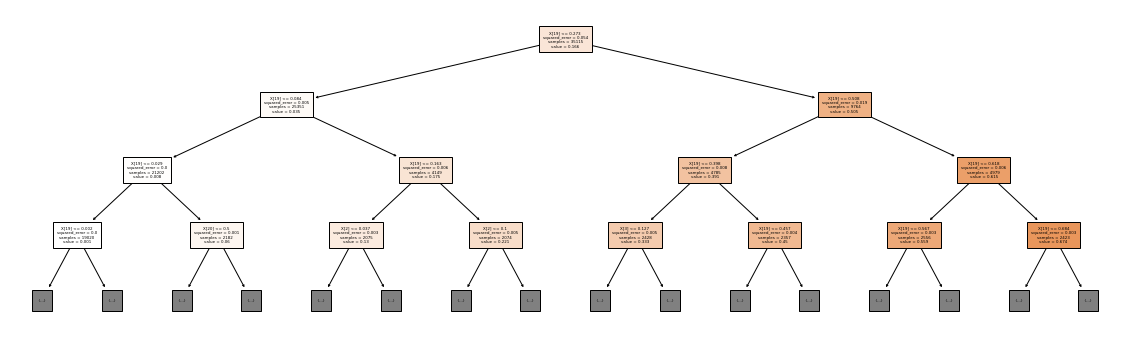

In [122]:
if isinstance(model, DecisionTreeRegressor):
    # plot model decision tree
    from sklearn.tree import plot_tree

    plt.figure(figsize=(20,6))
    plot_tree(model, filled=True, max_depth=3, fontsize=4)
    plt.savefig(f'./model_tree_{MODEL_NAME}.png')
    plt.show()

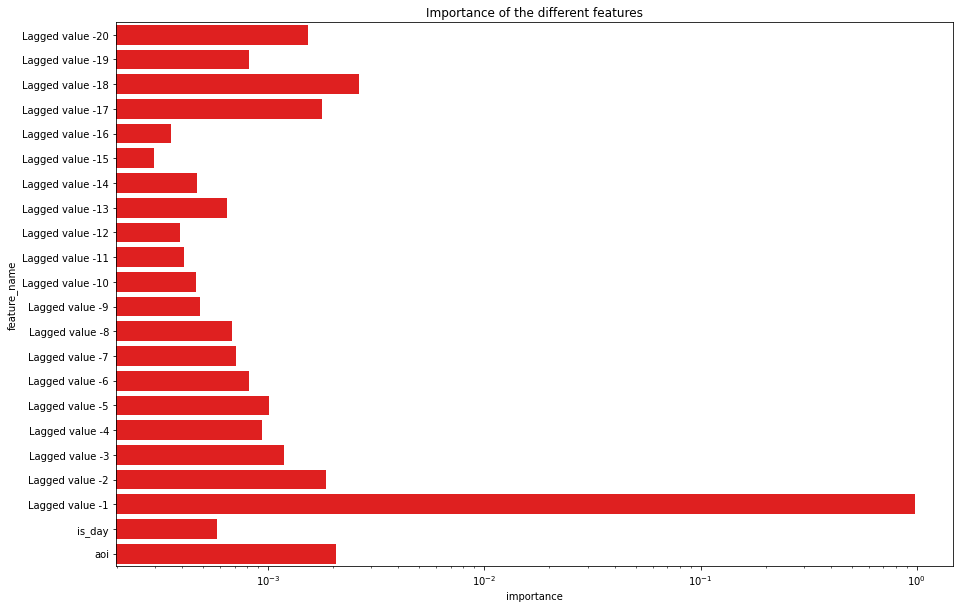

In [123]:
if isinstance(model, DecisionTreeRegressor):
    df = pd.DataFrame({
        "importance": model.feature_importances_,
        "feature_name": feature_names
    },)
    plt.figure(figsize=(15,10))
    sns.barplot(
        data=df,
        y="feature_name",
        x="importance",
        orient="h",
        color="red"
    );
    plt.title('Importance of the different features')
    # set log y axis
    plt.xscale("log")

It seems like that the last values are very important for the models (and also very old data points, probably for the seasonality).

For our expert features:
- The feature **id_day** doesn't seem to be very important for the model
- The **AOI**, on the other hand, appears to be one of the most important features

### Explain for a specific sample

Input shape (22,)


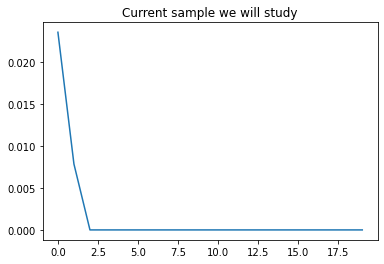

In [124]:
# Index of the sample we want to study
IDX = 0

# We do the same, by adding the expert features if needed
to_concat = [X_test[IDX]]
if test_is_day is not None:
    to_concat.append(test_is_day[IDX:IDX+1])
if test_aoi is not None:
    to_concat.append(test_aoi[IDX:IDX+1])
x_sample = np.concatenate(to_concat, axis=-1)
print("Input shape", x_sample.shape)

plt.plot(X_test[IDX])
plt.title('Current sample we will study')
plt.show()

### Lime

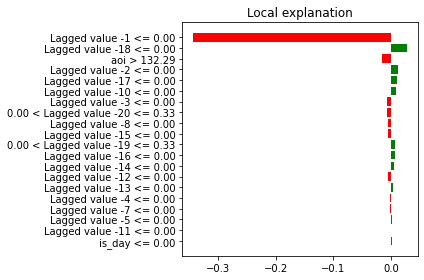

In [130]:
import lime
from lime import lime_tabular
import numpy as np

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_,
    mode="regression",
    feature_names=feature_names,
)


exp = explainer.explain_instance(x_sample, predict_fn=model.predict, num_features=20)

exp.as_pyplot_figure()
import matplotlib.pyplot as plt
plt.tight_layout()

If we take a look at a specific instance of the testing set, and try to understand how the model is making its prediction, we can see that the most important feature is the last value, and the model is building on it the next value. (it makes sense, because the irradiance is continuous).

Then, we can see that the model relies on very old data points (-18 and -19 lagged irradiance values).
The AOI also appears in the top positions, highlighting its importance for the model

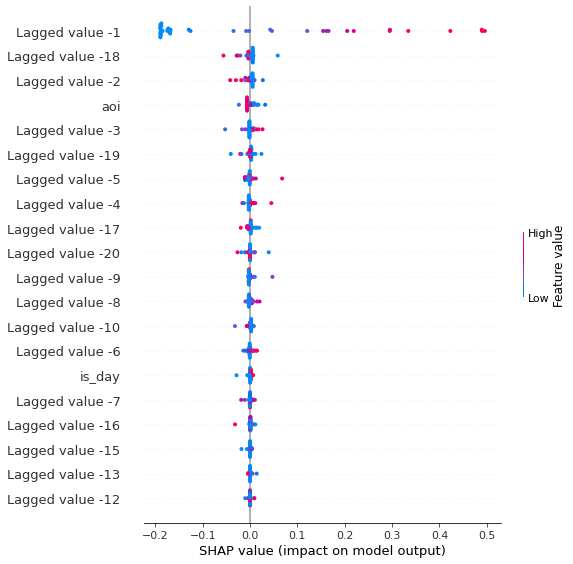

In [131]:
import shap
from IPython.display import clear_output


train = shap.sample(X_train_,40)
shap_explainer = shap.KernelExplainer(model.predict, train, feature_names=feature_names)
shap_values = shap_explainer.shap_values(train)
clear_output(wait=True)
shap.summary_plot(shap_values, train, feature_names=feature_names)


If we look a the shap values, we can see a similar pattern, with the last value being the most important, very old data points too and the AOI.

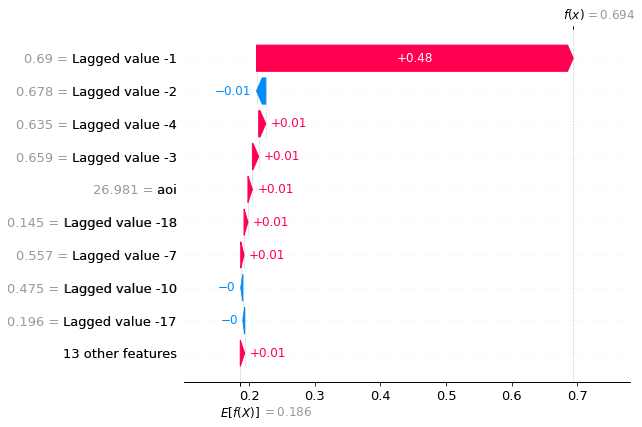

In [132]:
shap_explainer = shap.Explainer(model.predict, train, feature_names=feature_names)
shap_values = shap_explainer(train)
shap.plots.waterfall(shap_values[0])

The last value is clearly the most important feature for the models

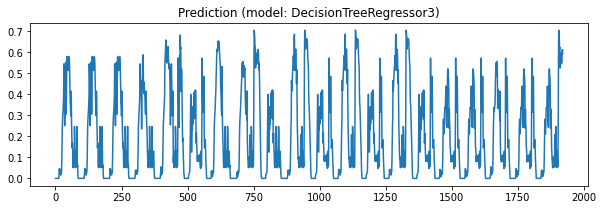

In [133]:
prediction = predictions[MODEL_NAME]
plt.figure(figsize=(10, 3))
plt.title(f"Prediction (model: {MODEL_NAME})")
plt.plot(prediction);

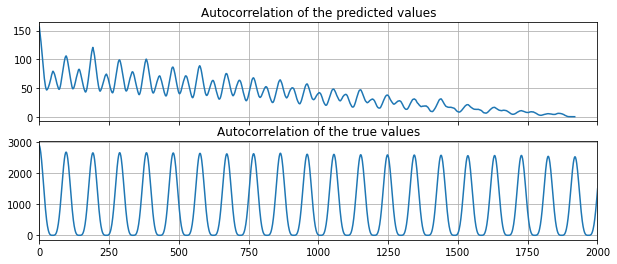

In [142]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,4))

axes[0].set_title('Autocorrelation of the predicted values')
axes[0].plot(autocorr(prediction))
axes[1].plot(autocorr(y_test))
axes[1].set_title('Autocorrelation of the true values')
plt.xlim(0, 2000)
axes[0].grid()
axes[1].grid()
plt.show()

We plot the autocorrelation of the prediction, we can see that the predicted signal, even if it is still auto-correlated, it is nothing like the true values

## Conclusion

We can now load the results and conclude

In [185]:
df = pd.read_csv('./results.csv', index_col=0).reset_index(drop=True)
df = df[(df.mse<1) & (df.model != "LinearRegression")]
df['expert_config'] = df.apply(lambda row: f"is_day={row['add_is_day']}, aoi={row['add_aoi']}", axis=1)
df.head()

,model,mse,mae,r2,loc_x,loc_y,year_train,year_test,dataset_size,number_to_generate,shift_size,add_is_day,add_aoi,remove_0,expert_config
1,DecisionTreeRegressor2,0.077183,0.197299,-0.621514,200,200,2020,2019,-1,1920,20,True,True,False,"is_day=True, aoi=True"
2,DecisionTreeRegressor3,0.045961,0.138737,0.034414,200,200,2020,2019,-1,1920,20,True,True,False,"is_day=True, aoi=True"
3,DecisionTreeRegressor4,0.043221,0.132918,0.091988,200,200,2020,2019,-1,1920,20,True,True,False,"is_day=True, aoi=True"
4,neural_net,0.010257,0.060287,0.784512,200,200,2020,2019,-1,1920,20,True,True,False,"is_day=True, aoi=True"
7,DecisionTreeRegressor2,0.071128,0.201270,-0.489799,200,200,2020,2019,-1,1920,20,True,True,False,"is_day=True, aoi=True"


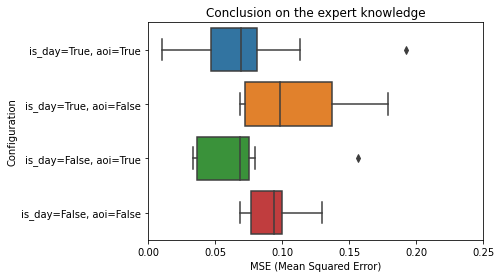

In [186]:
plt.figure()
plt.xlim(0, 0.25)
sns.boxplot(
    data=df,
    x="mse",
    y="expert_config",
)
plt.xlabel("MSE (Mean Squared Error)")
plt.ylabel("Configuration")
plt.title("Conclusion on the expert knowledge")
plt.savefig('../docs/conclusion_usefulness.png')
plt.show()

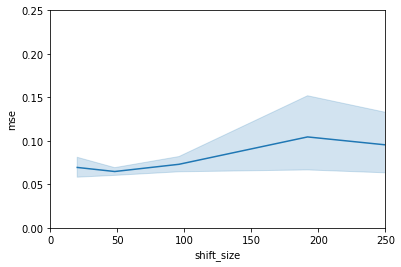

In [187]:
plt.figure()
plt.xlim(0, 250)
plt.ylim(0, 0.25)
sns.lineplot(
    x=df['shift_size'],
    y=df['mse']
)
plt.savefig('../docs/conclusion_shift_size.png')
plt.show()

In [199]:
METRICS = ['mse']

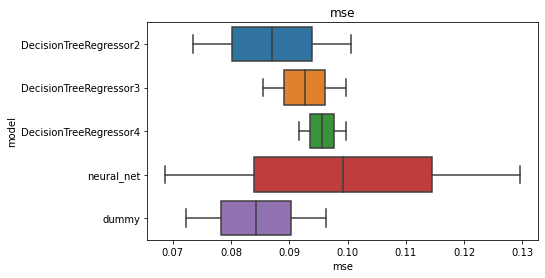

In [202]:
fig, axes = plt.subplots(1, len(METRICS), figsize=(7,4), sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, metric in enumerate(METRICS):
    sns.boxplot(
        data=df[df.expert_config == "is_day=False, aoi=False"],
        y="model",
        x=metric,
        ax=axes[i]
    )
    axes[i].set_title(metric)
plt.savefig('../docs/conclusion_models_without.png')
plt.show()

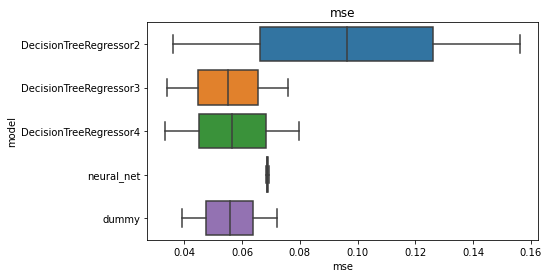

In [203]:
fig, axes = plt.subplots(1, len(METRICS), figsize=(7,4), sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, metric in enumerate(METRICS):
    sns.boxplot(
        data=df[(df.expert_config == "is_day=False, aoi=True")],
        y="model",
        x=metric,
        ax=axes[i]
    )
    axes[i].set_title(metric)
plt.savefig('../docs/conclusion_models_without.png')
plt.show()

To conclude, it seems like adding some expert knowledge help the models do better than a "dummy model" (the DecisionTreeRegressor3 is even better than the dummy by a few points.
Due to the fact that irradiance without clouds is easy to predict (using the AOI, we can compute it). When adding clouds, it makes the prediction harder to do, that is why a dummy model is better in much cases (and why weather predictions are hard to do).

If we focus on the the idea of adding expert knowledge into a system, we can conclude that adding those external data seems to improve greatly the efficiency of the models and their ability to predict long periods of time.